## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration using chessboard images

In [14]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

#parameter
nx = 9 #number of corners in x
ny = 6 #number of corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

fnames = []
objpoints_list = []
imgpoints_list = []
img_list = []
img_cal_list = []

# Make a list of calibration images
images = glob.glob('/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2img)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(img, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        print(fname)
        fnames.append(fname)
        img_list.append(img)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        img_cal_list.append(img)
        objpoints_list.append(objpoints)
        imgpoints_list.append(imgpoints)


/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration11.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration19.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration15.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration3.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration13.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration12.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration9.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration2.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration18.jpg
/home/kazuhiro/Dropbox

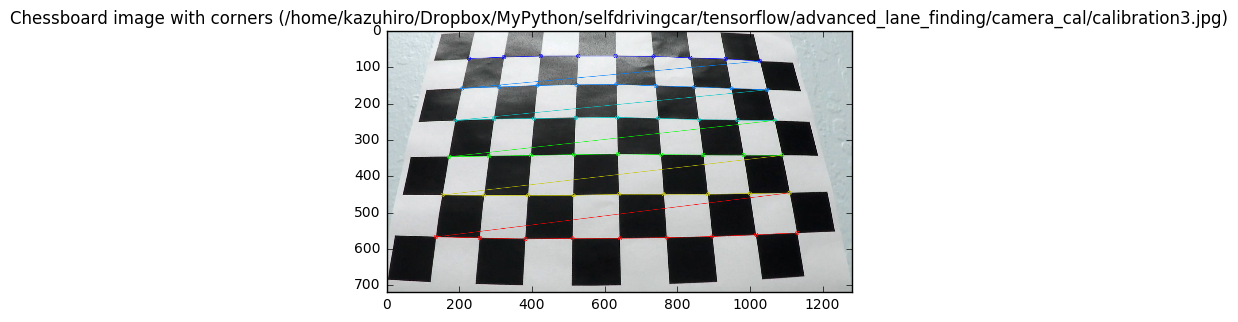

In [15]:
plt.imshow(img_list[3])
plt.title("Chessboard image with corners ("+fnames[3]+")")
plt.show()

## Distortion correction using chessboard images

In [27]:
def cal_undistort(img, objpoints, imgpoints):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2img)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[::-1], None, None)
    dist_coef = (mtx, dist, None, mtx)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist,mtx

undist_list = []
mtx_list = []

idx = 3

undist,mtx = cal_undistort(img_list[idx],objpoints_list[idx],imgpoints_list[idx])


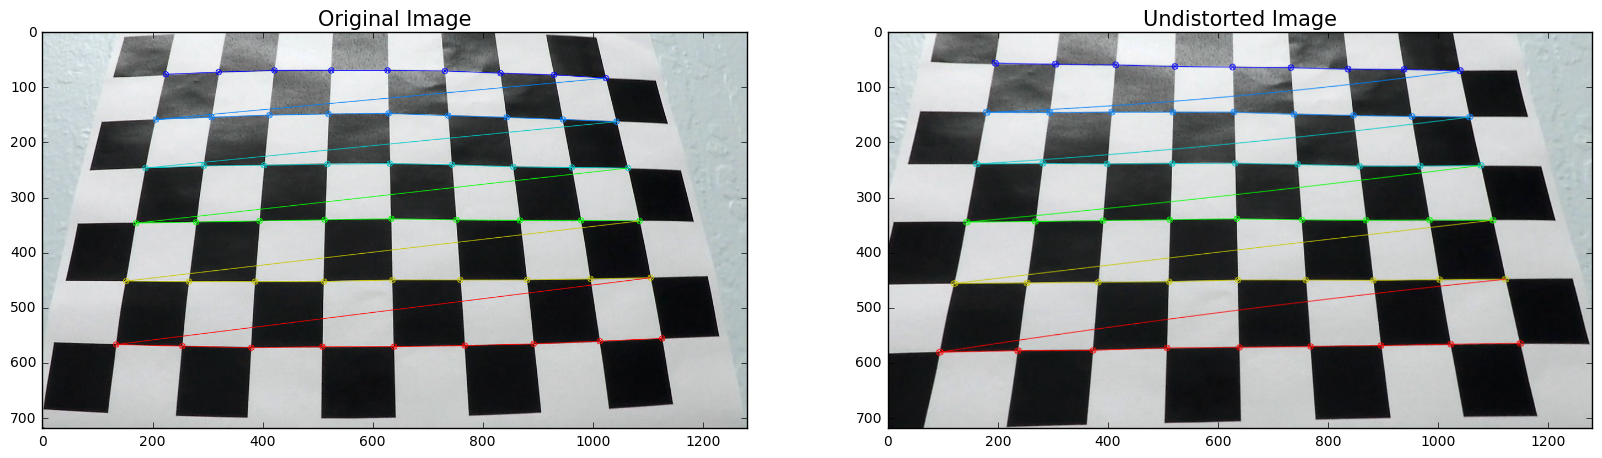

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_list[idx])
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=15)

## Perspective Transformation using chessboard images

In [29]:
def corners_unwarp(img, nx, ny, mtx, undist, offset):
    img = cv2.cvtColor(undist, cv2.COLOR_BGR2img)
    ret, corners = cv2.findChessboardCorners(img, (nx, ny), None)
    if(ret==True):
       cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
       img_size = (img.shape[1], img.shape[0])
       src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
       dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
    else:
        return None, None
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

img = img_list[3]
top_down, perspective_M = corners_unwarp(img, nx, ny,  mtx, undist, 100)

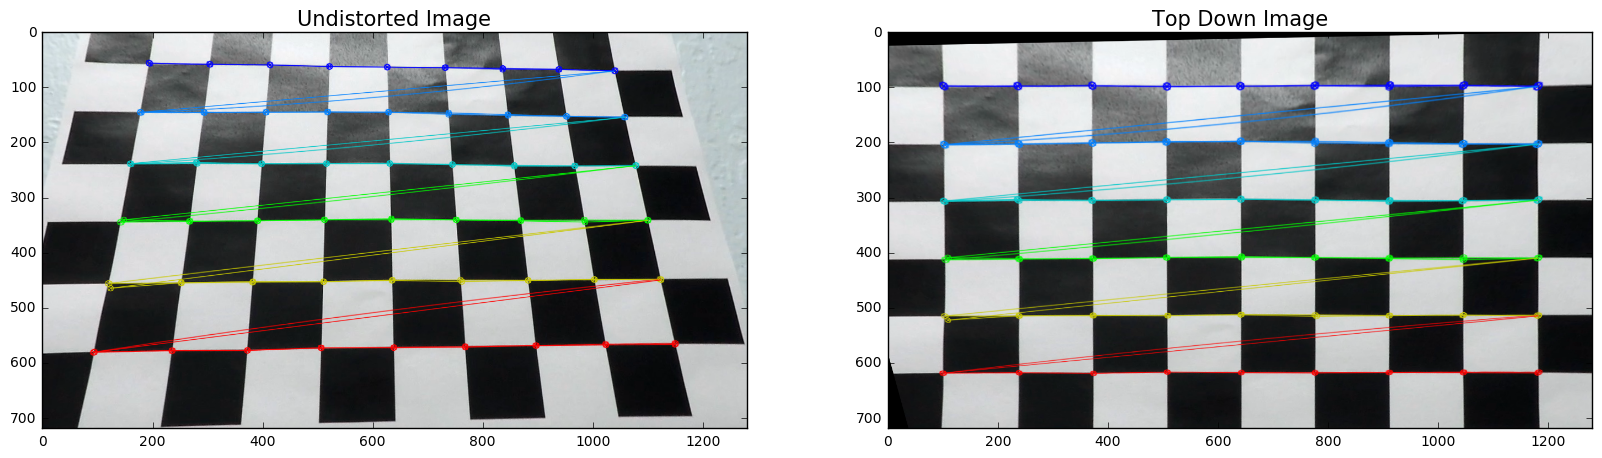

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=15)
ax2.imshow(top_down)
ax2.set_title('Top Down Image', fontsize=15)

## My Pipeline

In [119]:

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0)
        abs_sobel = np.absolute(sobelx)
    else: 
        sobely = cv2.Sobel(gray, cv2.CV_64F,0,1)
        abs_sobel = np.absolute(sobely)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, sobel_kernel)
    sobelxy = np.sqrt(np.square(sobelx)+np.square(sobely))
    abs_sobelxy = np.absolute(sobelxy)
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]  

    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=9, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=9, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | ((s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]))] = 1

    return combined

## Create threshhold binary images using test images

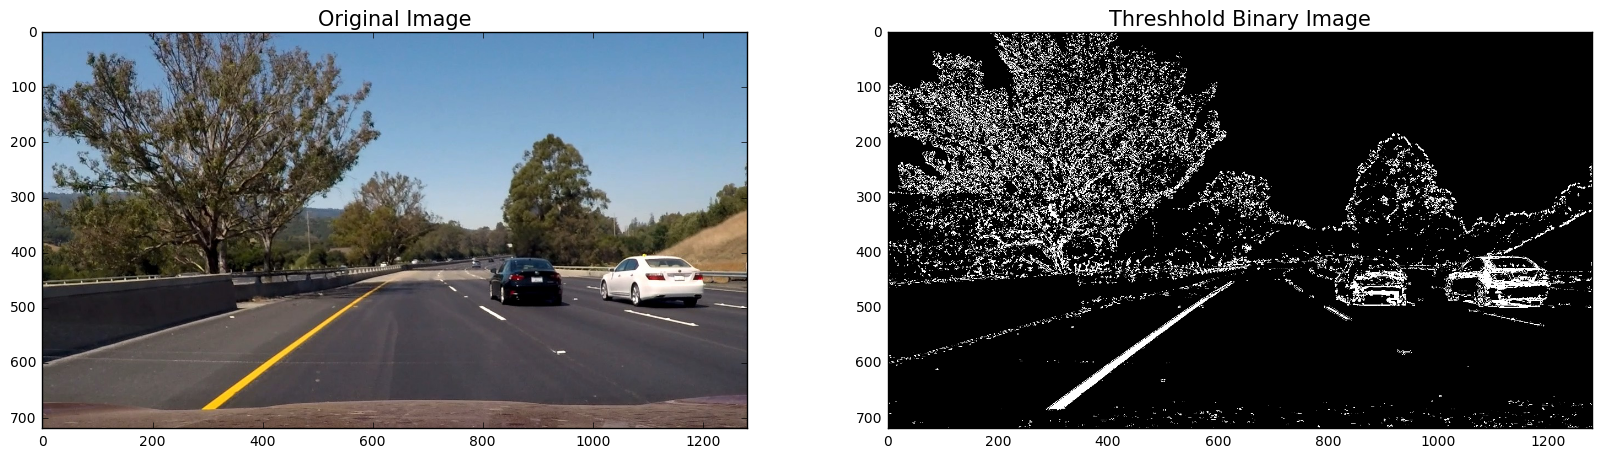

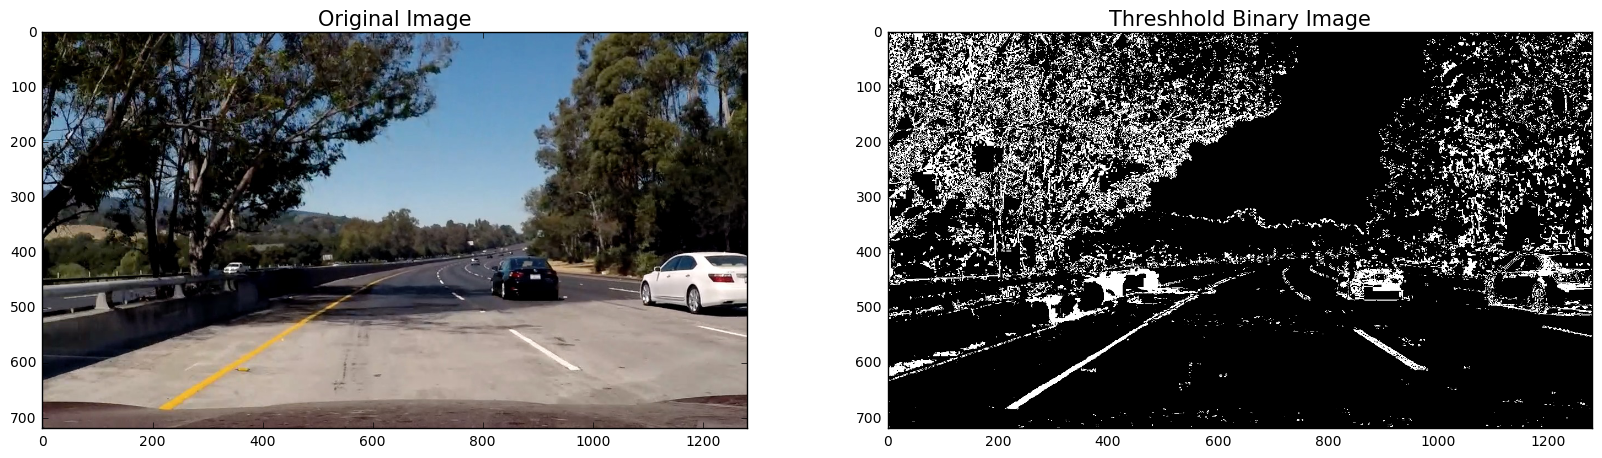

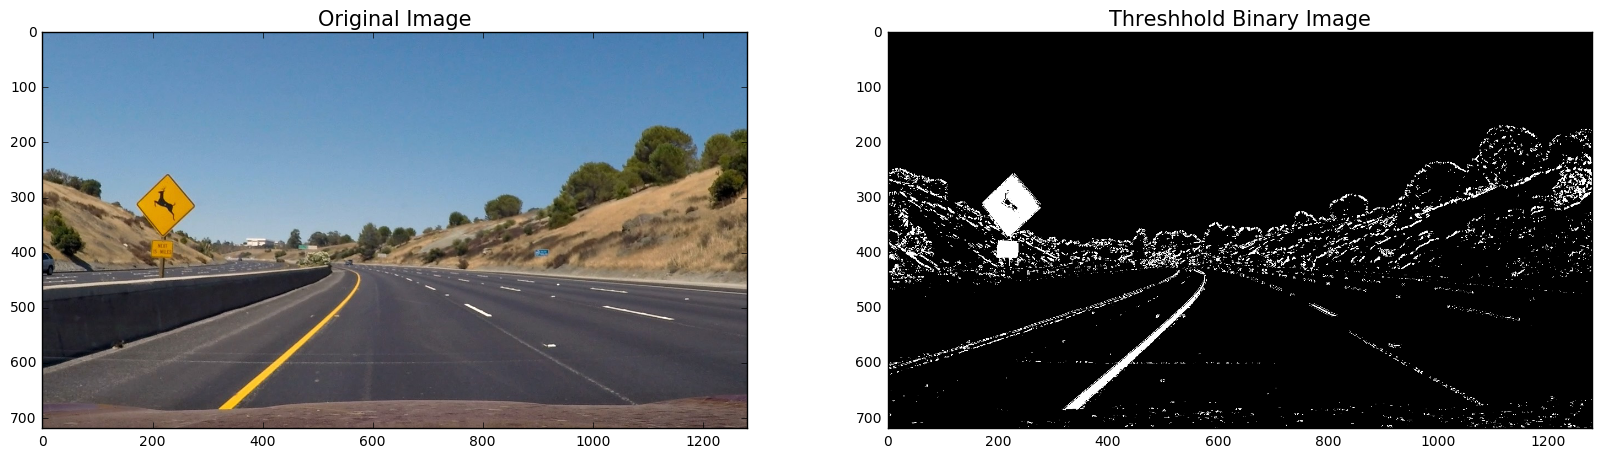

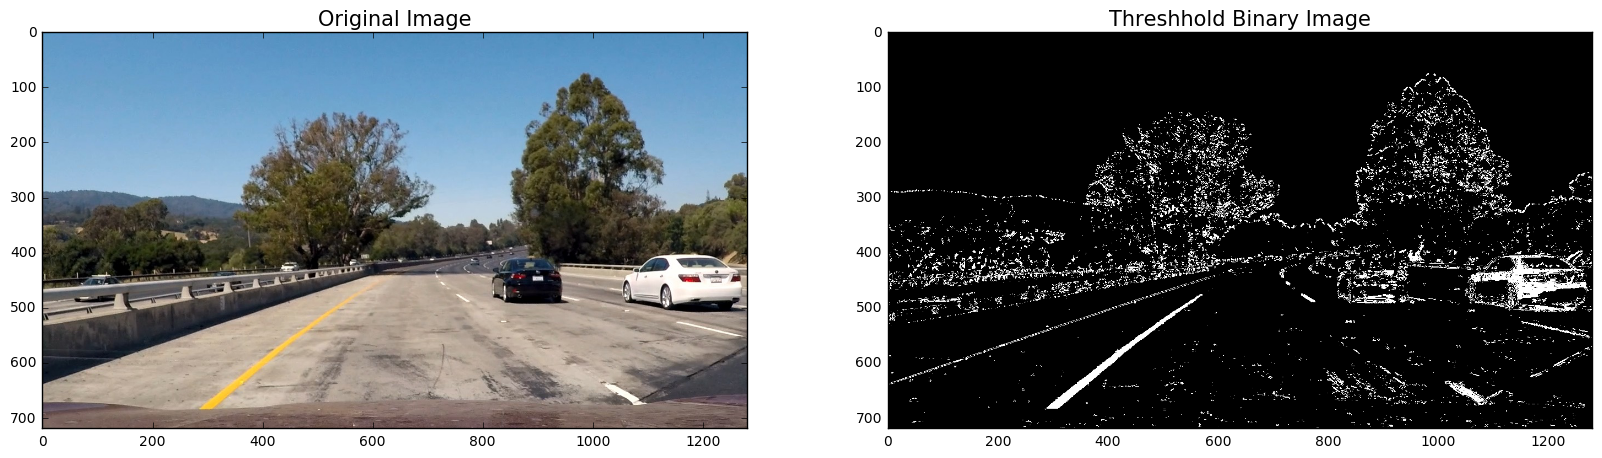

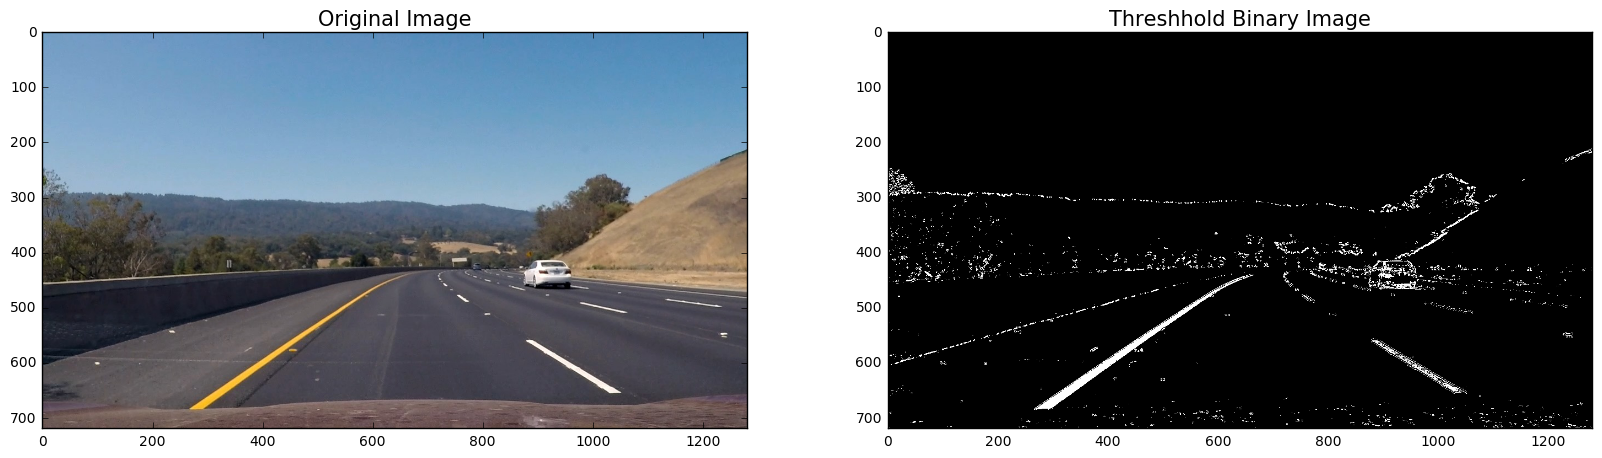

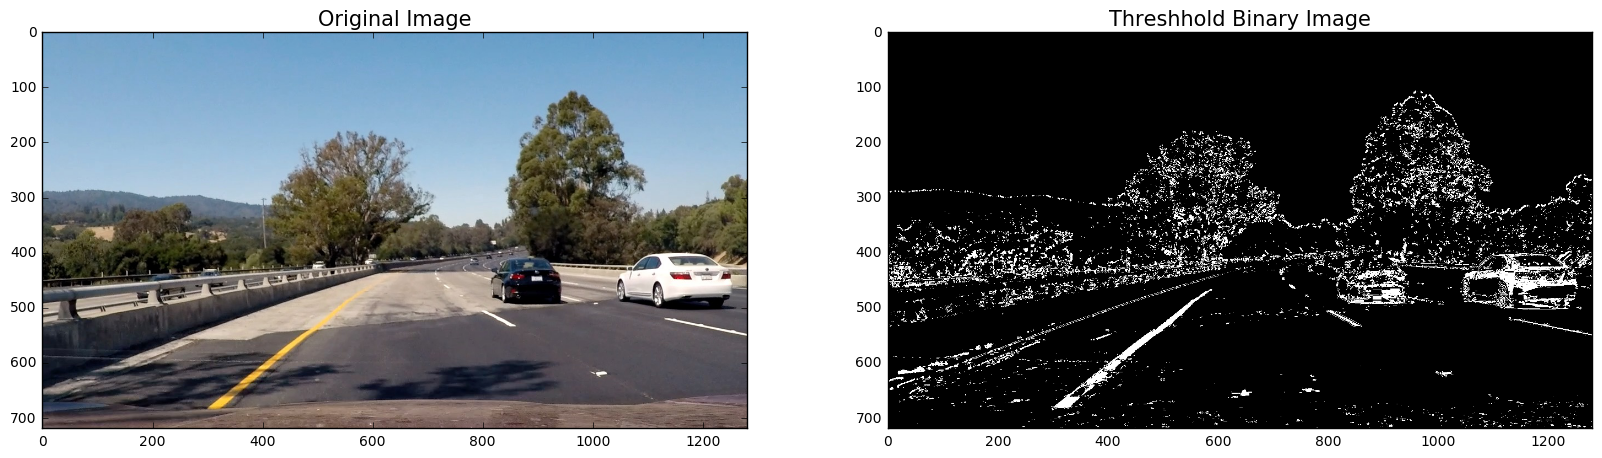

In [121]:
import matplotlib.image as mpimg

test_images = glob.glob('/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/test_images/test*.jpg')

test_images_list = []

for testimg in test_images:
    img_before = mpimg.imread(testimg)
    img_after = pipeline(img_before)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img_before)
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(img_after,cmap='gray')
    ax2.set_title('Threshhold Binary Image', fontsize=15)
    plt.show()